In [42]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 19

### Simple RNN 

Changes for the Assignment

- Tensorflow
- **Weather History Dataset**
- One hidden layer 
- ${Tanh}$ activation function
- **multi-class**
- ADAM
- Mini Batch
- L2 regularization
- ${Swish}$ Activation function

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [1]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

2023-12-01 11:49:37.200298: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 11:49:37.203123: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 11:49:37.245741: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 11:49:37.245785: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 11:49:37.245808: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
###----------------
### Some parameters
###----------------

inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 200 # number of epochs
ALPHA = 0.01 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2
TRAIN_SIZE = 14496 # Fix size of train set so that we have batches of same size
BATCH_SIZE = 32

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

### Dataset
##### - Weather History

In [3]:
data_df=pd.read_csv('weatherHistory.csv')

In [4]:
data_df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


In [5]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'],utc=True)

In [6]:
data_df.drop('Formatted Date',axis=1,inplace=True)

In [7]:
data_df

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,datetime
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.,2016-09-09 17:00:00+00:00
96449,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.,2016-09-09 18:00:00+00:00
96450,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.,2016-09-09 19:00:00+00:00
96451,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.,2016-09-09 20:00:00+00:00


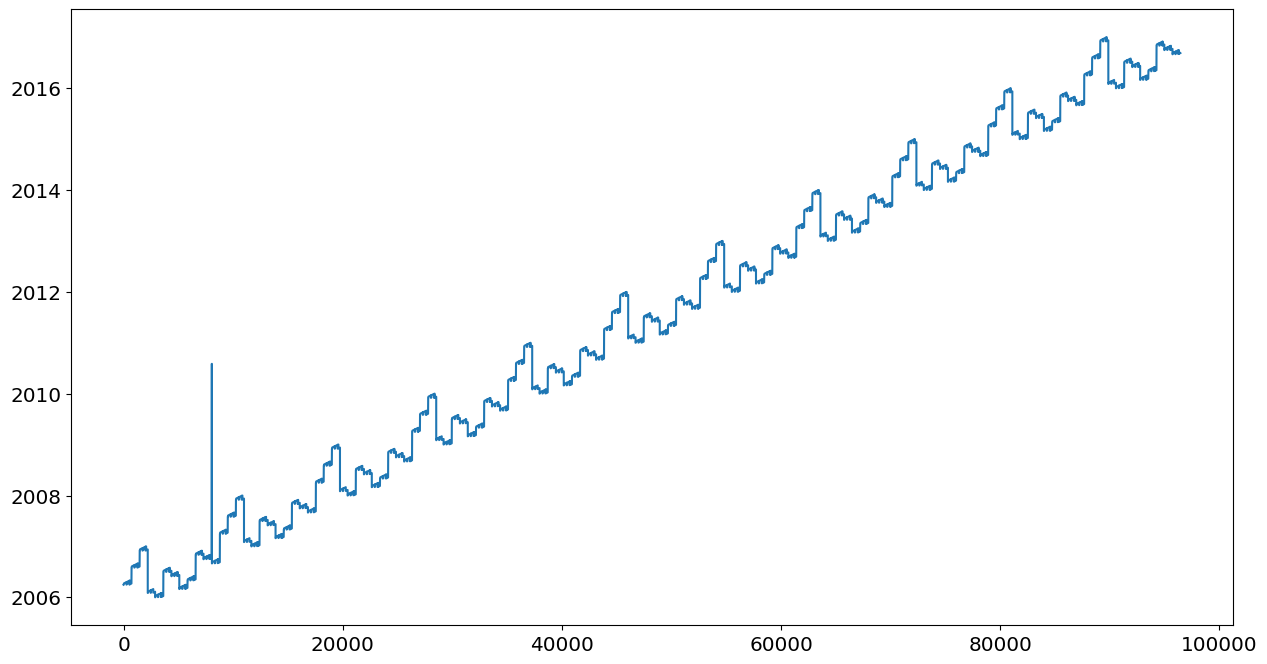

In [11]:
plt.plot(data_df['datetime']);

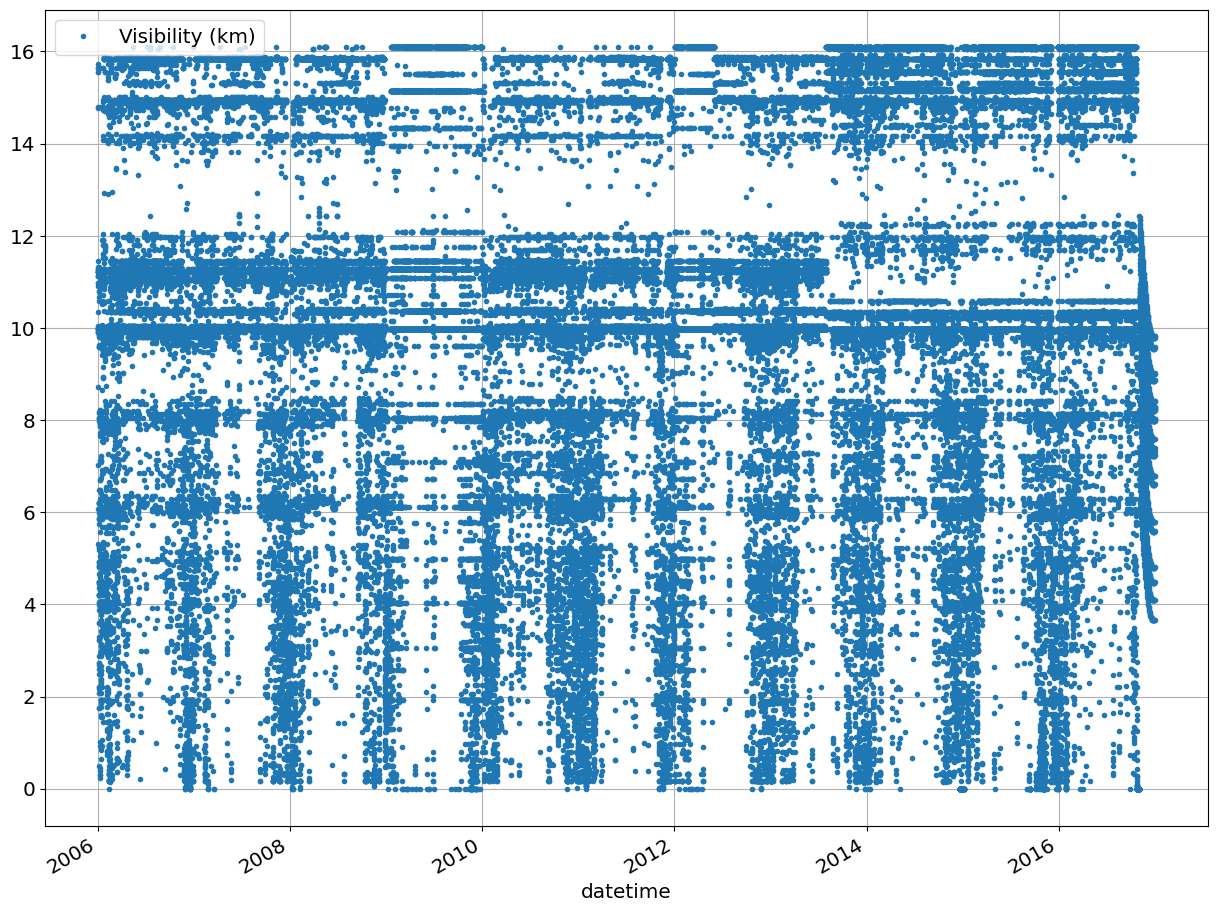

In [15]:
fig, ax = plt.subplots(figsize = (15,12))
data_df.plot(x='datetime', y='Visibility (km)', style=".", ax = ax);
ax.grid()

In [17]:
visi_df = data_df[['datetime','Visibility (km)']]
visi_df = temp_df.sort_values(by='datetime',axis=0,ascending=True)
visi_df = temp_df.reset_index(drop=True)
visi_df.head()

,datetime,Visibility (km)
0,2005-12-31 23:00:00+00:00,9.9820
1,2006-01-01 00:00:00+00:00,9.9015
2,2006-01-01 01:00:00+00:00,9.9015
3,2006-01-01 02:00:00+00:00,9.9015
4,2006-01-01 03:00:00+00:00,9.9015


In [18]:
visi_df.reset_index(drop=True, inplace = True)
visi_df.head()

,datetime,Visibility (km)
0,2005-12-31 23:00:00+00:00,9.9820
1,2006-01-01 00:00:00+00:00,9.9015
2,2006-01-01 01:00:00+00:00,9.9015
3,2006-01-01 02:00:00+00:00,9.9015
4,2006-01-01 03:00:00+00:00,9.9015


In [19]:
visi_df = visi_df.iloc[1:,:]

In [20]:
visi_df

,datetime,Visibility (km)
1,2006-01-01 00:00:00+00:00,9.9015
2,2006-01-01 01:00:00+00:00,9.9015
3,2006-01-01 02:00:00+00:00,9.9015
4,2006-01-01 03:00:00+00:00,9.9015
5,2006-01-01 04:00:00+00:00,9.9820
...,...,...
96448,2016-12-31 18:00:00+00:00,8.0178
96449,2016-12-31 19:00:00+00:00,7.2450
96450,2016-12-31 20:00:00+00:00,9.5795
96451,2016-12-31 21:00:00+00:00,8.4042


In [21]:
visi_df.head(25)

,datetime,Visibility (km)
1,2006-01-01 00:00:00+00:00,9.9015
2,2006-01-01 01:00:00+00:00,9.9015
3,2006-01-01 02:00:00+00:00,9.9015
4,2006-01-01 03:00:00+00:00,9.9015
5,2006-01-01 04:00:00+00:00,9.9820
6,2006-01-01 05:00:00+00:00,10.0464
7,2006-01-01 06:00:00+00:00,10.0303
8,2006-01-01 07:00:00+00:00,11.2056
9,2006-01-01 08:00:00+00:00,9.9820
10,2006-01-01 09:00:00+00:00,9.9820


In [22]:
96452/24

4018.8333333333335

In [23]:
4018*24

96432

In [24]:
96452-96432

20

In [25]:
visi_df = visi_df.iloc[:96432,:]

In [26]:
visi_df.head(25)

,datetime,Visibility (km)
1,2006-01-01 00:00:00+00:00,9.9015
2,2006-01-01 01:00:00+00:00,9.9015
3,2006-01-01 02:00:00+00:00,9.9015
4,2006-01-01 03:00:00+00:00,9.9015
5,2006-01-01 04:00:00+00:00,9.9820
6,2006-01-01 05:00:00+00:00,10.0464
7,2006-01-01 06:00:00+00:00,10.0303
8,2006-01-01 07:00:00+00:00,11.2056
9,2006-01-01 08:00:00+00:00,9.9820
10,2006-01-01 09:00:00+00:00,9.9820


In [27]:
final_df = visi_df['Visibility (km)'].to_numpy()

In [28]:
final_df.shape

(96432,)

In [29]:
final_df = final_df.reshape(4018,24)

In [30]:
final_df.shape

(4018, 24)

In [31]:
final_df = pd.DataFrame(final_df)

In [32]:
final_df['target'] = final_df[23]

In [33]:
final_df.drop(23,inplace=True, axis=1)

In [34]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,target
0,9.9015,9.9015,9.9015,9.9015,9.9820,10.0464,10.0303,11.2056,9.9820,9.9820,...,11.2056,11.3183,11.1251,11.1251,10.9158,11.2700,15.7297,14.7959,15.6492,15.6492
1,5.3130,15.5526,15.5526,14.7637,10.9802,10.9802,11.2378,11.1251,11.2056,11.4471,...,6.0697,5.2164,4.4919,4.4919,4.9105,4.0250,3.9767,5.2486,4.4436,4.4919
2,8.0500,4.4919,4.4919,5.2647,4.9105,4.9105,8.1466,10.8997,10.9480,11.2056,...,10.9480,10.8031,10.8997,10.8997,10.6743,10.7709,9.5795,9.6278,9.5795,9.5795
3,9.9015,5.8604,5.8604,6.4883,4.8139,4.8139,5.1842,3.8801,4.8300,8.1788,...,8.0500,7.9856,11.1251,11.1251,10.5938,11.1251,9.8532,9.8371,9.8049,9.9015
4,2.4794,6.1985,4.2021,4.0572,4.2021,3.6064,2.8819,2.6887,3.2844,3.6064,...,6.1985,4.8461,6.1985,6.1985,5.7477,4.2021,4.2021,3.2361,2.2057,2.2057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4013,4.4597,5.5706,3.6547,4.0894,5.7799,4.7978,7.3738,8.0178,7.5831,9.8049,...,8.1949,8.0017,7.2289,9.5473,8.3881,8.8550,9.7727,7.3094,7.9695,6.6010
4014,4.4597,5.5706,3.6547,4.0894,5.7799,4.7978,7.3738,8.0178,7.5831,9.8049,...,8.1949,8.0017,7.2289,9.5473,8.3881,8.8550,9.7727,7.3094,7.9695,6.6010
4015,4.4597,5.5706,3.6547,4.0894,5.7799,4.7978,7.3738,8.0178,7.5831,9.8049,...,8.1949,8.0017,7.2289,9.5634,8.3881,8.8550,9.7727,7.3255,7.9856,6.6010
4016,4.4597,5.5706,3.6547,4.0894,5.7799,4.7978,7.3899,8.0178,7.5992,9.8210,...,8.2110,8.0178,7.2289,9.5634,8.3881,8.8550,9.7888,7.3255,7.9856,6.6171


In [35]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4018 non-null   float64
 1   1       4018 non-null   float64
 2   2       4018 non-null   float64
 3   3       4018 non-null   float64
 4   4       4018 non-null   float64
 5   5       4018 non-null   float64
 6   6       4018 non-null   float64
 7   7       4018 non-null   float64
 8   8       4018 non-null   float64
 9   9       4018 non-null   float64
 10  10      4018 non-null   float64
 11  11      4018 non-null   float64
 12  12      4018 non-null   float64
 13  13      4018 non-null   float64
 14  14      4018 non-null   float64
 15  15      4018 non-null   float64
 16  16      4018 non-null   float64
 17  17      4018 non-null   float64
 18  18      4018 non-null   float64
 19  19      4018 non-null   float64
 20  20      4018 non-null   float64
 21  21      4018 non-null   float64
 22  

In [36]:
features_df = final_df.drop('target',axis=1)
label_df = final_df['target']

In [37]:
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,9.9015,9.9015,9.9015,9.9015,9.9820,10.0464,10.0303,11.2056,9.9820,9.9820,...,11.2056,11.2056,11.3183,11.1251,11.1251,10.9158,11.2700,15.7297,14.7959,15.6492
1,5.3130,15.5526,15.5526,14.7637,10.9802,10.9802,11.2378,11.1251,11.2056,11.4471,...,7.0357,6.0697,5.2164,4.4919,4.4919,4.9105,4.0250,3.9767,5.2486,4.4436
2,8.0500,4.4919,4.4919,5.2647,4.9105,4.9105,8.1466,10.8997,10.9480,11.2056,...,11.1251,10.9480,10.8031,10.8997,10.8997,10.6743,10.7709,9.5795,9.6278,9.5795
3,9.9015,5.8604,5.8604,6.4883,4.8139,4.8139,5.1842,3.8801,4.8300,8.1788,...,8.0500,8.0500,7.9856,11.1251,11.1251,10.5938,11.1251,9.8532,9.8371,9.8049
4,2.4794,6.1985,4.2021,4.0572,4.2021,3.6064,2.8819,2.6887,3.2844,3.6064,...,6.1985,6.1985,4.8461,6.1985,6.1985,5.7477,4.2021,4.2021,3.2361,2.2057


In [38]:
#features_df = np.reshape(features_df,(4018,23,1))
#features_df.shape

features_df = final_df.drop('target',axis=1)
label_df = final_df['target']
features_df.shape, label_df.shape

In [39]:
X_train, X_test, y_train, y_test = train_test_split(features_df, label_df, train_size=0.7, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2812, 23), (1206, 23), (2812,), (1206,))

###  Preparing Model

In [40]:
h_units = 64

input_shape = (23,1)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.SimpleRNN(units = h_units,
                                  input_shape = input_shape,
                                  activation = 'tanh',))

model.add(tf.keras.layers.Dense(units=1,
                               activation='linear'))

In [41]:
model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'])

In [42]:
model_fit = model.fit(X_train,y_train, 
                      batch_size=32, 
                      epochs=100, 
                      verbose=1, 
                      validation_data=(X_test, y_test))

Epoch 1/100
88/88 [==============================] - 2s 14ms/step - loss: 85.8731 - accuracy: 7.1124e-04 - val_loss: 23.6868 - val_accuracy: 0.0017
Epoch 2/100
88/88 [==============================] - 1s 12ms/step - loss: 14.0894 - accuracy: 3.5562e-04 - val_loss: 8.4045 - val_accuracy: 0.0075
Epoch 3/100
88/88 [==============================] - 1s 12ms/step - loss: 6.0855 - accuracy: 3.5562e-04 - val_loss: 5.0620 - val_accuracy: 0.0075
Epoch 4/100
88/88 [==============================] - 1s 12ms/step - loss: 4.0916 - accuracy: 3.5562e-04 - val_loss: 3.9939 - val_accuracy: 0.0075
Epoch 5/100
88/88 [==============================] - 1s 12ms/step - loss: 3.5238 - accuracy: 3.5562e-04 - val_loss: 3.6499 - val_accuracy: 0.0075
Epoch 6/100
88/88 [==============================] - 1s 12ms/step - loss: 3.2878 - accuracy: 3.5562e-04 - val_loss: 3.4962 - val_accuracy: 0.0075
Epoch 7/100
88/88 [==============================] - 1s 12ms/step - loss: 3.2204 - accuracy: 0.0000e+00 - val_loss: 3.488

Epoch 57/100
88/88 [==============================] - 1s 12ms/step - loss: 2.6758 - accuracy: 3.5562e-04 - val_loss: 3.2459 - val_accuracy: 0.0066
Epoch 58/100
88/88 [==============================] - 1s 12ms/step - loss: 2.6486 - accuracy: 3.5562e-04 - val_loss: 3.2425 - val_accuracy: 0.0075
Epoch 59/100
88/88 [==============================] - 1s 12ms/step - loss: 2.6289 - accuracy: 0.0000e+00 - val_loss: 3.2074 - val_accuracy: 0.0066
Epoch 60/100
88/88 [==============================] - 1s 12ms/step - loss: 2.6166 - accuracy: 0.0000e+00 - val_loss: 3.2003 - val_accuracy: 0.0066
Epoch 61/100
88/88 [==============================] - 1s 12ms/step - loss: 2.6161 - accuracy: 3.5562e-04 - val_loss: 3.2088 - val_accuracy: 0.0066
Epoch 62/100
88/88 [==============================] - 1s 12ms/step - loss: 2.6007 - accuracy: 3.5562e-04 - val_loss: 3.2395 - val_accuracy: 0.0066
Epoch 63/100
88/88 [==============================] - 1s 12ms/step - loss: 2.5916 - accuracy: 3.5562e-04 - val_loss: 3

In [43]:
y_pred = model.predict(X_test)

38/38 [==============================] - 0s 5ms/step


In [44]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_tf_hist(hist_df):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [38]:
history = model_fit.history

In [39]:
history = pd.DataFrame(history)

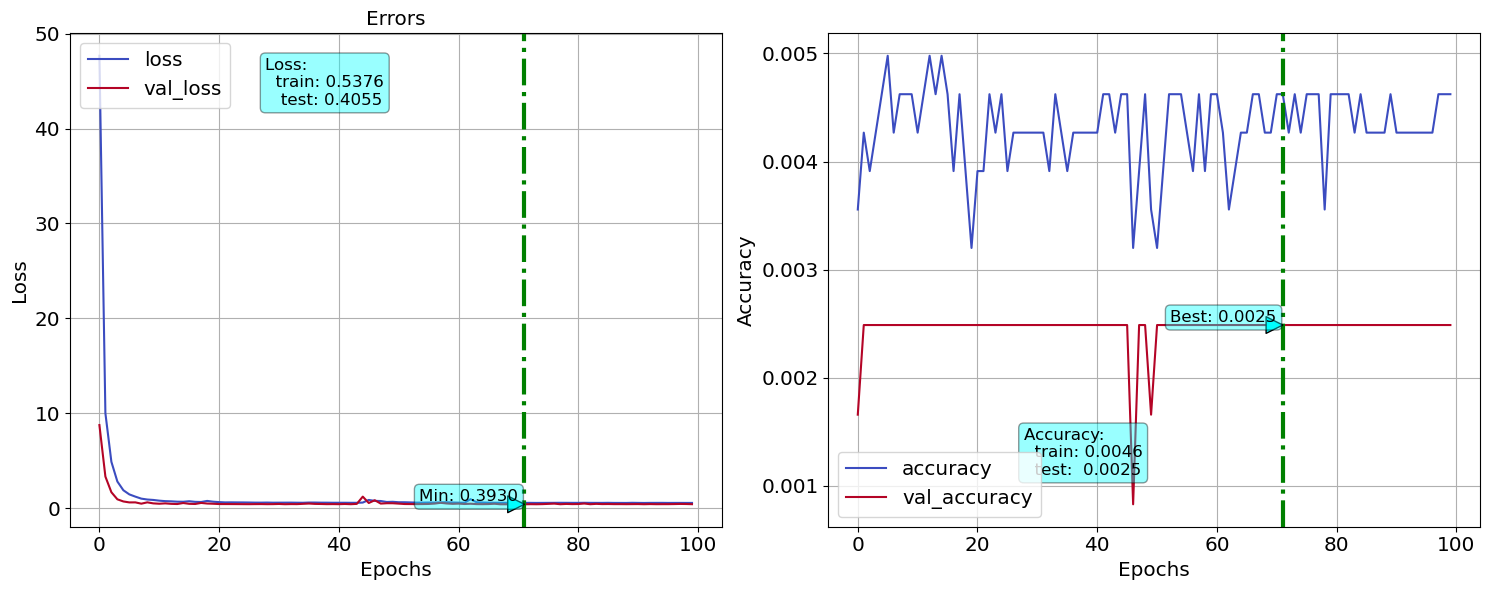

In [40]:
plot_tf_hist(history)